## AutoML Framework Benchmark

Этот ноутбук предназначен для сравнения производительности и качества различных AutoML фреймворков на двух задачах: регрессии (предсказание цены квартиры) и бинарной классификации (предсказание оттока клиентов).

**Необходимые библиотеки:**
- `pandas`, `numpy`: для работы с данными.
- `scikit-learn`: для вспомогательных функций (разделение данных, метрики, кодировщики).
- `lazypredict`: простой AutoML фреймворк для быстрого получения бейзлайнов.
- `lightautoml`: мощный AutoML фреймворк, часто используемый в соревнованиях.
- `flaml`: быстрый и экономичный AutoML фреймворк от Microsoft.
- `matplotlib`, `seaborn`: для возможной визуализации (хотя в данном скрипте не используются активно).

**Установка:** Раскомментируйте и выполните следующую ячейку, если библиотеки не установлены в вашем окружении.

In [1]:
# %pip install pandas numpy scikit-learn gensim lazypredict lightautoml "flaml[blendsearch]" matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

from lazypredict.Supervised import LazyClassifier, LazyRegressor
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from flaml import AutoML

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
print("Библиотеки импортированы.")

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
Библиотеки импортированы.


## Сравнение AutoML Фреймворков

| Фича / Фреймворк             | LazyPredict                                   | LightAutoML (LAMA)                                    | FLAML                                                                 |
| :-------------------------- | :-------------------------------------------- | :---------------------------------------------------- | :-------------------------------------------------------------------- |
| **Работа с категориальными** | Нет (требует числовых данных)                  | **Да** (Встроенные стратегии: frequency, label, etc.) | **Да** (object/category dtype, использует LGBM/CatBoost native или one-hot) |
| **Обработка новых категорий (в тесте)** | Не применимо (нужна внешняя обработка) | **Да** (Обычно маппит в NaN/unknown категорию)       | Зависит от оценщика (LGBM/CatBoost могут, другие - нет). Лучше обрабатывать вне. |
| **Ограничение ресурсов**   | Нет                                           | **Да** (`timeout`, `cpu_limit`, `memory_limit`)         | **Да** (`time_budget`, `n_concurrent_trials`). Нет прямых лимитов CPU/RAM. |
| **Используемые модели**      | Фиксированный список (~30-40) sklearn-based   | LightGBM, Linear L2 (+ CatBoost опционально). Сложные пайплайны (стекинг, ансамбли). | Конфигурируемый список (`estimator_list`): LGBM, XGBoost, CatBoost, RF, ET, Linear, SVM, etc. |
| **Параллельный запуск**     | Да (внутренне через joblib для моделей)      | **Да** (`cpu_limit`)                                  | **Да** (`n_jobs` для некоторых оценщиков и CV)                       |
| **Требуется ли предобработка (мин.)** | **Да** (OHE/LabelEncoding, Imputation)      | **Нет** (для базовых задач)                           | **Нет** (для базовых задач с типами object/category)                  |

## Функции Предобработки

Здесь определены функции для подготовки данных к обучению моделей.

1.  `clean_col_names`: Приводит имена колонок к формату, безопасному для использования в различных библиотеках (удаляет пробелы и спецсимволы).
2.  `apply_noisy_target_encoding`: Реализует метод сглаженного таргет-кодирования с добавлением шума.
    *   Вычисляет статистики (среднее и количество) по каждой категории *только на обучающих данных*.
    *   Применяет сглаживание, зависящее от количества примеров в категории (меньше сглаживания для часто встречающихся категорий).
    *   Кодирует категориальный признак вычисленным сглаженным средним.
    *   Добавляет случайный шум (масштабированный стандартным отклонением целевой переменной) для регуляризации.
    *   Обрабатывает категории, встречающиеся только в тестовом наборе, заменяя их глобальным средним по таргету (вычисленному на трейне) + шум.
    *   Удаляет исходную категориальную колонку.
3.  `preprocess_churn` и `preprocess_price`: Основные функции предобработки для каждой задачи.
    *   Загружают данные.
    *   Очищают имена колонок.
    *   Выполняют специфичную для задачи базовую обработку (например, `TotalSpent` в churn).
    *   Разделяют на признаки (X) и цель (y).
    *   Заполняют пропуски в числовых признаках медианой.
    *   Определяют категориальные признаки.
    *   **Ключевое:** В зависимости от флага `use_target_encoding`:
        *   Если `True`: Применяют `apply_noisy_target_encoding` к небинарным категориальным признакам. Бинарные ('Yes'/'No'/...) кодируются в 0/1 напрямую.
        *   Если `False`: Применяют One-Hot Encoding к небинарным категориальным признакам и выравнивают колонки между трейном и тестом. Бинарные кодируются в 0/1.
    *   Удаляют колонки, оставшиеся нечисловыми после всех преобразований.
    *   Возвращают готовые `X_train`, `y_train`, `X_test`, `y_test`.

In [3]:
def clean_col_names(df):
    """Очищает имена колонок DataFrame."""
    df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
    return df

def apply_noisy_target_encoding(train_df, test_df, cat_col, target_col, noise_scale=0.01, min_samples_leaf=5, smoothing_factor=10.0):
    """
    Применяет сглаженное таргет-кодирование с шумом.
    Обучается на train_df, применяется к train_df и test_df.
    Возвращает модифицированные train_df и test_df.
    """
    print(f"Applying noisy target encoding to '{cat_col}'...")

    try:
        train_target_numeric = pd.to_numeric(train_df[target_col], errors='coerce')
        if train_target_numeric.isnull().any():
            print(f"  Warning: Coercing non-numeric target values in '{target_col}' to NaN for encoding '{cat_col}'. Using remaining values for mean.")
            train_target_numeric = train_target_numeric.dropna()
            if train_target_numeric.empty:
                print(f"  Error: Target column '{target_col}' has no numeric values after coercion. Skipping encoding for '{cat_col}'.")
                return train_df, test_df

        if train_df[target_col].nunique() <= 2 and pd.api.types.is_numeric_dtype(train_df[target_col].dtype):
            print(f"  Detected binary-like target for '{cat_col}'. Ensuring 0/1 for mean calculation.")
            if not set(train_df[target_col].astype(float).unique()).issubset({0.0, 1.0}):
                le_target = LabelEncoder()
                train_target_numeric = pd.Series(le_target.fit_transform(train_df[target_col]), index=train_df.index)
                print(f"  Target encoded to {le_target.classes_} for mean calculation.")

    except (ValueError, TypeError):
        print(f"  Warning: Target column '{target_col}' is not numeric. Attempting LabelEncoding for encoding '{cat_col}'.")
        le_target = LabelEncoder()
        train_target_numeric = pd.Series(le_target.fit_transform(train_df[target_col].values), index=train_df.index)


    global_mean = train_target_numeric.mean()
    target_std = train_target_numeric.std()
    if target_std == 0: # Handle zero std case
        target_std = 1.0
        print("  Warning: Target standard deviation is zero. Using 1.0 for noise scaling.")


    stats = train_df.groupby(cat_col)[target_col].agg(['mean', 'count'])

    smoothing = 1 / (1 + np.exp(-(stats['count'] - min_samples_leaf) / smoothing_factor))

    encoded_map = global_mean * (1 - smoothing) + stats['mean'] * smoothing

    new_col_name = f"{cat_col}_TgtEncoded"

    train_encoded_values = train_df[cat_col].map(encoded_map)
    train_noise = np.random.normal(0, noise_scale * target_std, len(train_df))
    train_df[new_col_name] = train_encoded_values
    train_df[new_col_name].fillna(global_mean, inplace=True) # Fill NAs from map with global mean first
    train_df[new_col_name] += train_noise # Add noise after filling


    test_encoded_values = test_df[cat_col].map(encoded_map)
    test_noise = np.random.normal(0, noise_scale * target_std, len(test_df))
    test_df[new_col_name] = test_encoded_values
    test_df[new_col_name].fillna(global_mean, inplace=True) # Fill NAs (new categories) with global mean
    test_df[new_col_name] += test_noise # Add noise after filling

    print(f"  Finished encoding '{cat_col}' into '{new_col_name}'.")
    return train_df, test_df

def preprocess_churn(train_path, test_path, target_column='Churn', use_target_encoding=True, noise_scale=0.05):
    print(f"Preprocessing Churn data: {train_path}, {test_path}...")
    try:
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)
    except FileNotFoundError as e:
        print(f"Ошибка: Файл не найден - {e}.")
        return None, None, None, None

    df_train = clean_col_names(df_train)
    df_test = clean_col_names(df_test)
    target_column = "".join (c if c.isalnum() else "_" for c in str(target_column))

    df_train['TotalSpent'] = pd.to_numeric(df_train['TotalSpent'], errors='coerce').fillna(0)
    df_test['TotalSpent'] = pd.to_numeric(df_test['TotalSpent'], errors='coerce').fillna(0)

    X_train = df_train.drop(target_column, axis=1)
    y_train = df_train[target_column]
    X_test = df_test.drop(target_column, axis=1)
    y_test = df_test[target_column]

    categorical_cols_train = X_train.select_dtypes(include=['object', 'category']).columns
    categorical_cols_test = X_test.select_dtypes(include=['object', 'category']).columns
    common_categorical_cols = list(set(categorical_cols_train) & set(categorical_cols_test))

    cols_to_process_later = []

    for col in common_categorical_cols:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)
        unique_vals_train = set(X_train[col].unique())
        map_dict = {'Yes': 1, 'No': 0, 'No phone service': 0, 'No internet service': 0}
        is_binary_like = all(str(val).lower() in ['yes', 'no', 'no phone service', 'no internet service', 'nan', 'none'] for val in unique_vals_train)

        if is_binary_like and len(unique_vals_train - {'nan', 'None'}) <= 2:
            X_train[col] = X_train[col].map(map_dict).fillna(0).astype(int)
            X_test[col] = X_test[col].map(map_dict).fillna(0).astype(int)
            print(f"Column '{col}' mapped to binary.")
        else:
            cols_to_process_later.append(col)

    if use_target_encoding and cols_to_process_later:
        print(f"Applying noisy target encoding to: {cols_to_process_later}")
        X_train_copy = X_train.copy() # Работаем с копиями, чтобы не менять оригиналы вне функции
        X_test_copy = X_test.copy()
        X_train_copy[target_column] = y_train
        X_test_copy[target_column] = y_test # Временно добавляем таргет для консистентности, хотя он не используется в тесте
        for col in cols_to_process_later:
            X_train_copy, X_test_copy = apply_noisy_target_encoding(X_train_copy, X_test_copy, col, target_column, noise_scale=noise_scale)
        X_train = X_train_copy.drop(columns=[target_column])
        X_test = X_test_copy.drop(columns=[target_column])
        # Удаляем оригинальные категориальные колонки, которые были закодированы
        X_train = X_train.drop(columns=[c for c in cols_to_process_later if c in X_train.columns])
        X_test = X_test.drop(columns=[c for c in cols_to_process_later if c in X_test.columns])


    elif not use_target_encoding and cols_to_process_later:
        print(f"Applying OneHotEncoding to: {cols_to_process_later}")
        X_train = pd.get_dummies(X_train, columns=cols_to_process_later, dummy_na=False, drop_first=False)
        X_test = pd.get_dummies(X_test, columns=cols_to_process_later, dummy_na=False, drop_first=False)
        train_cols = set(X_train.columns); test_cols = set(X_test.columns)
        missing_in_test = list(train_cols - test_cols); missing_in_train = list(test_cols - train_cols)
        for c in missing_in_test: X_test[c] = 0
        for c in missing_in_train: X_train[c] = 0
        final_train_cols = [col for col in X_train.columns if col != target_column]
        X_test = X_test[final_train_cols]

    non_numeric_train_cols = X_train.select_dtypes(exclude=np.number).columns
    if len(non_numeric_train_cols) > 0:
        print(f"Warning: Dropping final non-numeric columns: {list(non_numeric_train_cols)}")
        X_train = X_train.drop(columns=non_numeric_train_cols)
        cols_to_drop_in_test = [col for col in non_numeric_train_cols if col in X_test.columns]
        X_test = X_test.drop(columns=cols_to_drop_in_test)

    if set(X_train.columns) == set(X_test.columns):
        X_test = X_test[X_train.columns]
    else:
        print("Warning: Column mismatch after preprocessing churn data.")
        # Попробуем выровнять еще раз на всякий случай
        train_cols = set(X_train.columns)
        test_cols = set(X_test.columns)
        missing_in_test = list(train_cols - test_cols)
        for c in missing_in_test: X_test[c] = 0
        X_test = X_test[X_train.columns]


    print("Churn preprocessing finished.")
    return X_train, y_train, X_test, y_test


def preprocess_price(train_path, test_path, target_column='price', use_target_encoding=True, noise_scale=0.01):
    print(f"Preprocessing Price data: {train_path}, {test_path}...")
    try:
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)
    except FileNotFoundError as e:
        print(f"Ошибка: Файл не найден - {e}.")
        return None, None, None, None

    df_train = clean_col_names(df_train)
    df_test = clean_col_names(df_test)
    target_column = "".join (c if c.isalnum() else "_" for c in str(target_column))

    X_train = df_train.drop(target_column, axis=1)
    y_train = df_train[target_column]
    X_test = df_test.drop(target_column, axis=1)
    y_test = df_test[target_column]

    numeric_cols_train = X_train.select_dtypes(include=np.number).columns
    numeric_cols_test = X_test.select_dtypes(include=np.number).columns
    common_numeric_cols = list(set(numeric_cols_train) & set(numeric_cols_test))
    for col in common_numeric_cols:
        median_val = X_train[col].median()
        X_train[col].fillna(median_val, inplace=True)
        X_test[col].fillna(median_val, inplace=True)

    categorical_cols_train = X_train.select_dtypes(include=['object', 'category']).columns
    categorical_cols_test = X_test.select_dtypes(include=['object', 'category']).columns
    common_categorical_cols = list(set(categorical_cols_train) & set(categorical_cols_test))

    for col in common_categorical_cols:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)
        mode_val = X_train[col].mode()[0] if not X_train[col].mode().empty else "Missing"
        X_train[col].fillna(mode_val, inplace=True)
        X_test[col].fillna(mode_val, inplace=True)
        train_categories = set(X_train[col].unique())
        test_categories = set(X_test[col].unique())
        new_categories_in_test = list(test_categories - train_categories)
        if new_categories_in_test:
            print(f"Warning: New categories found in test column '{col}': {new_categories_in_test}. Replacing with mode '{mode_val}'.")
            X_test[col] = X_test[col].apply(lambda x: mode_val if x in new_categories_in_test else x)

    if use_target_encoding and common_categorical_cols:
        print(f"Applying noisy target encoding to: {common_categorical_cols}")
        X_train_copy = X_train.copy()
        X_test_copy = X_test.copy()
        X_train_copy[target_column] = y_train
        X_test_copy[target_column] = y_test
        for col in common_categorical_cols:
            X_train_copy, X_test_copy = apply_noisy_target_encoding(X_train_copy, X_test_copy, col, target_column, noise_scale=noise_scale)
        X_train = X_train_copy.drop(columns=[target_column])
        X_test = X_test_copy.drop(columns=[target_column])
        # Удаляем оригинальные категориальные колонки
        X_train = X_train.drop(columns=[c for c in common_categorical_cols if c in X_train.columns])
        X_test = X_test.drop(columns=[c for c in common_categorical_cols if c in X_test.columns])

    elif not use_target_encoding and common_categorical_cols:
        print(f"Applying OneHotEncoding to: {common_categorical_cols}")
        X_train = pd.get_dummies(X_train, columns=common_categorical_cols, dummy_na=False, drop_first=False)
        X_test = pd.get_dummies(X_test, columns=common_categorical_cols, dummy_na=False, drop_first=False)
        train_cols = set(X_train.columns); test_cols = set(X_test.columns)
        missing_in_test = list(train_cols - test_cols); missing_in_train = list(test_cols - train_cols)
        for c in missing_in_test: X_test[c] = 0
        for c in missing_in_train: X_train[c] = 0
        final_train_cols = [col for col in X_train.columns if col != target_column]
        X_test = X_test[final_train_cols]

    non_numeric_train_cols = X_train.select_dtypes(exclude=np.number).columns
    if len(non_numeric_train_cols) > 0:
        print(f"Warning: Dropping final non-numeric columns: {list(non_numeric_train_cols)}")
        X_train = X_train.drop(columns=non_numeric_train_cols)
        cols_to_drop_in_test = [col for col in non_numeric_train_cols if col in X_test.columns]
        X_test = X_test.drop(columns=cols_to_drop_in_test)

    if set(X_train.columns) == set(X_test.columns):
        X_test = X_test[X_train.columns]
    else:
        print("Warning: Column mismatch after preprocessing price data.")
        train_cols = set(X_train.columns)
        test_cols = set(X_test.columns)
        missing_in_test = list(train_cols - test_cols)
        for c in missing_in_test: X_test[c] = 0
        X_test = X_test[X_train.columns] # Повторная попытка выравнивания

    print("Price preprocessing finished.")
    return X_train, y_train, X_test, y_test

print("Preprocessing functions defined.")

Preprocessing functions defined.


## Функции-обертки для AutoML

Эти функции стандартизируют запуск каждого фреймворка и возврат результатов.

*   Принимают на вход подготовленные данные (`X_train`, `y_train`, `X_test`, `y_test`) или оригинальные DataFrame для LAMA (если не используется внешняя предобработка категорий).
*   Принимают тип задачи (`classification` или `regression`) и необходимые метрики.
*   Принимают параметры ограничений ресурсов (`timeout`, `time_budget` и т.д.) через `**kwargs`, что позволяет гибко настраивать каждый запуск.
*   Замеряют время выполнения.
*   Вычисляют и возвращают финальную метрику на **тестовом** наборе данных.
*   Обрабатывают возможные ошибки во время выполнения.

In [4]:
def run_lazypredict(X_train, y_train, X_test, y_test, task_type, **kwargs): # Убрали n_jobs из аргументов по умолчанию
    """Запускает LazyPredict и возвращает метрику и время."""
    print(f"\n--- Running LazyPredict for {task_type} ---")
    start_time = time.time()
    best_model_metric = np.nan
    models = None
    metric_name = 'Unknown'
    elapsed_time = np.nan
    # n_jobs больше не передается явно в конструкторы Lazy*

    try:
        if task_type == 'classification':
            metric_name = 'ROC AUC'
            le = LabelEncoder()
            y_train_enc = le.fit_transform(y_train)
            y_test_enc = le.transform(y_test)
            # Убрали n_jobs
            clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=roc_auc_score, predictions=False)
            models, _ = clf.fit(X_train, X_test, y_train_enc, y_test_enc)
            if models is not None and not models.empty and 'ROC AUC' in models.columns:
                best_model_metric = models['ROC AUC'].max()
                print("\nLazyPredict Classifier Model Performance (Sorted by Time):")
                print(models.sort_values(by='Time Taken', ascending=False).to_markdown(floatfmt=".4f"))
            else:
                best_model_metric = 'N/A'
                print("LazyClassifier models DataFrame is empty or lacks 'ROC AUC' column.")

        elif task_type == 'regression':
            metric_name = 'RMSE'
            # Убрали n_jobs
            reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), predictions=False)
            y_train_clean = y_train.fillna(y_train.median())
            y_test_clean = y_test.fillna(y_train.median())
            try:
                models, _ = reg.fit(X_train, X_test, y_train_clean, y_test_clean)
                if models is not None and not models.empty:
                    rmse_col_name = '<lambda>' if '<lambda>' in models.columns else 'Custom' if 'Custom' in models.columns else 'RMSE'
                    if rmse_col_name in models.columns:
                        best_model_metric = models[rmse_col_name].min()
                    else:
                        best_model_metric = 'N/A'
                        print(f"LazyRegressor: Could not find metric column ('{rmse_col_name}' or 'RMSE').")
                    print("\nLazyPredict Regressor Model Performance (Sorted by Time):")
                    print(models.sort_values(by='Time Taken', ascending=False).to_markdown(floatfmt=".4f"))
                else:
                    best_model_metric = 'N/A'
                    print("LazyRegressor models DataFrame is empty.")
            except ValueError as ve:
                if "All arrays must be of the same length" in str(ve):
                    print("LazyPredict failed internally (ValueError: All arrays must be of the same length). Likely due to some models failing.")
                    best_model_metric = 'Internal Error'
                else:
                    raise ve
        else:
            raise ValueError("task_type must be 'classification' or 'regression'")

    except Exception as e:
        print(f"LazyPredict failed: {e}")
        traceback.print_exc()
        best_model_metric = 'Error'

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"LazyPredict finished in {elapsed_time:.2f} seconds. Best internal {metric_name}: {best_model_metric if isinstance(best_model_metric, (int, float)) else best_model_metric}")
    return best_model_metric, elapsed_time

def run_lightautoml(train_df, test_df, target_col, roles, task: Task, timeout=None, cpu_limit=4, memory_limit=16, **kwargs):
    """Запускает LightAutoML и возвращает метрику на тесте и время."""
    print(f"\n--- Running LightAutoML for task: {task.name} (Timeout: {timeout}, CPU Limit: {cpu_limit}) ---")
    automl_params = {'task': task, 'cpu_limit': cpu_limit, 'memory_limit': memory_limit}
    if timeout is not None:
        automl_params['timeout'] = timeout

    automl = TabularAutoML(**automl_params)
    score = np.nan
    elapsed_time = np.nan
    metric_name = 'Unknown'

    try:
        start_time = time.time()
        _ = automl.fit_predict(train_df, roles=roles, verbose=0)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"LightAutoML fit_predict completed in {elapsed_time:.2f} seconds.")

        test_preds = automl.predict(test_df).data
        print(f"Prediction on test data completed. Shape: {test_preds.shape if hasattr(test_preds, 'shape') else 'N/A'}")

        y_test_true = test_df[target_col]

        print("Calculating metric on test set...")
        if task.name == 'binary':
            metric_name = 'ROC AUC'
            y_test_true_enc = y_test_true
            if not pd.api.types.is_numeric_dtype(y_test_true) or set(y_test_true.dropna().unique()) > {0, 1}:
                le_test = LabelEncoder()
                y_test_true_enc = le_test.fit_transform(y_test_true)
                print(f"Warning: LAMA test target re-encoded to {le_test.classes_}")

            if test_preds.ndim == 1 or test_preds.shape[1] == 1:
                test_preds_proba = test_preds.flatten()
            elif test_preds.shape[1] == 2:
                try:
                    le_check = LabelEncoder().fit(train_df[target_col])
                    if 1 in le_check.classes_:
                        pos_idx = list(le_check.classes_).index(1)
                        test_preds_proba = test_preds[:, pos_idx]
                        print(f"LAMA: Using column {pos_idx} for positive class probabilities.")
                    else:
                        print("LAMA Warning: Class '1' not definitively found. Using column 1.")
                        test_preds_proba = test_preds[:, 1]
                except Exception:
                    print("LAMA Warning: Could not confirm positive class index. Using column 1.")
                    test_preds_proba = test_preds[:, 1]
            else:
                raise ValueError(f"Unexpected prediction array shape {test_preds.shape}.")
            score = roc_auc_score(y_test_true_enc, test_preds_proba)

        elif task.name == 'reg':
            metric_name = 'RMSE'
            y_test_true_clean = y_test_true.fillna(y_test_true.median())
            if test_preds.ndim == 2 and test_preds.shape[1] > 0:
                mse = mean_squared_error(y_test_true_clean, test_preds[:, 0])
                score = np.sqrt(mse)
            elif test_preds.ndim == 1:
                mse = mean_squared_error(y_test_true_clean, test_preds)
                score = np.sqrt(mse)
            else: raise ValueError(f"Prediction array shape {test_preds.shape} is unexpected.")
        else:
            raise ValueError("Unsupported task type")

        print("Metric calculation successful.")
        print(f"LightAutoML finished. Test {metric_name}: {score:.4f}. Time: {elapsed_time:.2f} seconds.")

    except Exception as e:
        print(f"LightAutoML failed during execution: {e}")
        traceback.print_exc()
        score = 'Error'
        if 'start_time' in locals() and np.isnan(elapsed_time): elapsed_time = time.time() - start_time
        elif np.isnan(elapsed_time): elapsed_time = 0
        print(f"LightAutoML failed after {elapsed_time:.2f} seconds.")

    return score, elapsed_time


def run_flaml(X_train, y_train, X_test, y_test, task_type, metric_name, time_budget=None, **kwargs):
    """Запускает FLAML и возвращает метрику на тесте и время."""
    n_jobs = kwargs.get('n_jobs', -1) # Получаем n_jobs из kwargs
    print(f"\n--- Running FLAML for {task_type} (Time Budget: {time_budget}, n_jobs: {n_jobs}) ---")
    automl = AutoML()
    settings = {
        "metric": metric_name,
        "task": task_type,
        "log_file_name": f"flaml_{task_type}.log",
        "n_jobs": n_jobs, # Используем n_jobs из аргументов
        "seed": 42,
        "eval_method": "auto",
        "early_stop": False if time_budget is None else True
    }
    if time_budget is not None:
        settings["time_budget"] = time_budget

    score = np.nan
    elapsed_time = np.nan

    try:
        start_time = time.time()

        if task_type == 'classification' and not pd.api.types.is_numeric_dtype(y_train):
            le_flaml = LabelEncoder()
            y_train_enc = le_flaml.fit_transform(y_train)
            y_test_enc = le_flaml.transform(y_test)
        else:
            y_train_enc = y_train
            y_test_enc = y_test

        if not isinstance(X_train, pd.DataFrame):
            X_train_df = pd.DataFrame(X_train)
            X_test_df = pd.DataFrame(X_test)
        else:
            X_train_df = X_train.copy()
            X_test_df = X_test.copy()

        X_train_df.columns = X_train_df.columns.astype(str)
        X_test_df.columns = X_test_df.columns.astype(str)

        automl.fit(X_train_df, y_train_enc, **settings)
        end_time = time.time()
        elapsed_time = end_time - start_time

        if task_type == 'classification':
            proba = automl.predict_proba(X_test_df)
            if proba.shape[1] == 2: test_preds_proba = proba[:, 1]
            elif proba.shape[1] == 1:
                print("Warning: FLAML predict_proba returned 1 column. Assuming probabilities for class 1.")
                test_preds_proba = proba.flatten()
            else: raise ValueError(f"Unexpected shape from predict_proba: {proba.shape}")
            score = roc_auc_score(y_test_enc, test_preds_proba)
            metric_display_name = 'ROC AUC'
        elif task_type == 'regression':
            y_test_clean = pd.Series(y_test_enc).fillna(pd.Series(y_train_enc).median()).values
            test_preds = automl.predict(X_test_df)
            mse = mean_squared_error(y_test_clean, test_preds)
            score = np.sqrt(mse)
            metric_display_name = 'RMSE'
        else:
            raise ValueError("Unsupported task")

        print(f"FLAML finished in {elapsed_time:.2f} seconds. Best model: {automl.best_estimator}. Test {metric_display_name}: {score:.4f}")

    except Exception as e:
        print(f"FLAML failed: {e}")
        traceback.print_exc()
        score = 'Error'
        if 'start_time' in locals() and np.isnan(elapsed_time): elapsed_time = time.time() - start_time
        elif np.isnan(elapsed_time): elapsed_time = 0
        print(f"FLAML failed after {elapsed_time:.2f} seconds.")

    return score, elapsed_time

print("AutoML runner functions updated.")

AutoML runner functions updated.


## Конфигурация Бенчмарка

Здесь задаются параметры для каждой задачи (пути к данным, целевая переменная, тип задачи, метрики) и для каждого AutoML фреймворка (функция-запускатель, необходимость внешней предобработки, настройки по умолчанию).

Также определены словари `NO_LIMITS_SETTINGS` и `LIMITED_SETTINGS_120S` для переопределения настроек фреймворков при различных сценариях запуска (например, без ограничений по времени или с лимитом в 120 секунд).


In [5]:
# Ячейка 5: Конфигурация задач и фреймворков (обновленная)

TASKS = {
    "user_churn": {
        "train_path": "train_churn.csv",
        "test_path": "test_churn.csv",
        "target": "Churn",
        "task_type": "classification",
        "metric": "roc_auc",
        "lama_metric": "auc",
        "lama_task": "binary",
        "preprocessing_func": preprocess_churn,
        "goal": "maximize"
    },
    "flat_price": {
        "train_path": "train_price.csv",
        "test_path": "test_price.csv",
        "target": "price",
        "task_type": "regression",
        "metric": "rmse",
        "lama_metric": "mse",
        "lama_task": "reg",
        "preprocessing_func": preprocess_price,
        "goal": "minimize"
    }
}

FRAMEWORKS = {
    "lazypredict": {
        "runner": run_lazypredict,
        "preprocessing_required": True,
        "settings": {} # n_jobs передается через kwargs в раннер
    },
    "LightAutoML": {
        "runner": run_lightautoml,
        "preprocessing_required": False,
        "settings": {
            "timeout": 600,
            "cpu_limit": 4, # Стандартный лимит CPU
            "memory_limit": 16
        }
    },
    "FLAML": {
        "runner": run_flaml,
        "preprocessing_required": False,
        "settings": {
            "time_budget": 180, # Умеренный бюджет времени
            "estimator_list": "auto",
            "n_jobs": 4 # Стандартный лимит ядер
        }
    }
}

STANDARD_RUN_SETTINGS = {
    "LightAutoML": {"timeout": 2000, "cpu_limit": 4}, # Пример умеренных лимитов
    "FLAML": {"time_budget": 2000, "n_jobs": 4}       # Пример умеренных лимитов
    # LazyPredict игнорирует эти настройки, использует свои внутренние или n_jobs=-1 из раннера
}


PARALLEL_RUN_SETTINGS = {
    "LightAutoML": {
        "timeout": 1800, # Больше времени
        "cpu_limit": -1, # Использовать все ядра
        "memory_limit": 32
    },
    "FLAML": {
        "time_budget": 1800, # Больше времени
        "n_jobs": -1 # Использовать все ядра
    }
}

print("Updated configurations defined.")

Updated configurations defined.


## Функция Запуска Бенчмарка (`run_automl_comparison`)

Эта функция организует процесс сравнения:
*   Итерирует по всем задачам, определенным в `tasks_config`.
*   Для каждой задачи вызывает соответствующую функцию предобработки (`preprocessing_func`), передавая ей флаг `use_target_encoding` для выбора стратегии кодирования категорий.
*   Итерирует по всем фреймворкам, определенным в `frameworks_config`.
*   Передает специфичные настройки (`run_settings`) в функцию-запускатель фреймворка.
*   Решает, какие данные передать каждому фреймворку:
    *   LazyPredict *всегда* получает данные после предобработки (с OHE или Target Encoding).
    *   LightAutoML и FLAML получают данные *после* предобработки, *если* `use_target_encoding=True`.
    *   LightAutoML и FLAML *могут* получать *оригинальные* данные, *если* `use_target_encoding=False` (это требует, чтобы их внутренние механизмы обработки категорий были включены или адаптации кода). **В текущей реализации LAMA получит оригинальные данные, если `use_target_encoding=False`, а FLAML все равно получит предобработанные (с OHE).**
*   Собирает результаты (метрику, время, флаг предобработки) в словарь.
*   Возвращает итоговый словарь с результатами.

In [6]:
def run_automl_comparison(tasks_config, frameworks_config, run_settings=None, use_target_encoding=True):
    """Запускает бенчмарк AutoML с заданными настройками предобработки."""
    benchmark_results = {}

    for task_name, task_info in tasks_config.items():
        print(f"\n{'='*15} Starting Task: {task_name} ({task_info['task_type']}) {'='*15}")
        encoding_type = "Target Encoding" if use_target_encoding else "OneHot Encoding"
        print(f"Using Preprocessing with: {encoding_type}")
        benchmark_results[task_name] = {}

        print("--- Running Preprocessing ---")
        preprocess_args = {
            "train_path": task_info["train_path"],
            "test_path": task_info["test_path"],
            "target_column": task_info["target"],
            "use_target_encoding": use_target_encoding
        }
        if use_target_encoding:
            noise = 0.05 if task_info['task_type'] == 'classification' else 0.01
            preprocess_args['noise_scale'] = noise
            print(f"Using noise_scale: {noise}")

        X_train, y_train, X_test, y_test = task_info["preprocessing_func"](**preprocess_args)

        if X_train is None:
            print(f"Skipping task {task_name} due to preprocessing error.")
            continue
        print("--- Preprocessing Finished ---")

        train_df_orig, test_df_orig = None, None
        target_clean = "".join (c if c.isalnum() else "_" for c in str(task_info["target"]))

        for fw_name, fw_info in frameworks_config.items():
            print(f"\n--- Running Framework: {fw_name} ---")

            fw_settings = fw_info["settings"].copy()
            if run_settings and fw_name in run_settings:
                fw_settings.update(run_settings[fw_name])

            runner_func = fw_info["runner"]
            score = 'Skipped'
            elapsed_time = 'Skipped'
            preprocessing_needed = True

            try:
                if fw_name == "LightAutoML":
                    train_lama_df = X_train.copy()
                    train_lama_df[target_clean] = y_train
                    test_lama_df = X_test.copy()
                    test_lama_df[target_clean] = y_test
                    roles = {'target': target_clean}
                    lama_task_obj = Task(task_info["lama_task"], metric=task_info["lama_metric"])
                    score, elapsed_time = runner_func(train_lama_df, test_lama_df, target_clean, roles, lama_task_obj, **fw_settings)

                elif fw_name == "FLAML":
                    score, elapsed_time = runner_func(X_train, y_train, X_test, y_test,
                                                      task_info["task_type"], task_info["metric"],
                                                      **fw_settings)
                elif fw_name == "lazypredict":
                    score, elapsed_time = runner_func(X_train, y_train, X_test, y_test, task_info["task_type"], **fw_settings)
                else:
                    print(f"Runner for framework {fw_name} not implemented correctly.")

            except Exception as e:
                print(f"Framework {fw_name} failed for task {task_name}: {e}")
                traceback.print_exc()
                score = 'Run Error'
                elapsed_time = 'Run Error'

            benchmark_results[task_name][fw_name] = {
                'Metric': score,
                'Time': elapsed_time,
                'Preprocessing Required': preprocessing_needed
            }

        print(f"\n{'='*15} Task Finished: {task_name} {'='*15}")

    return benchmark_results

print("Benchmark runner function updated.")

Benchmark runner function updated.


## Запуск Бенчмарка (Сценарий 1: Без ограничений + Target Encoding)

Запускаем сравнение фреймворков, используя:
*   **Target Encoding с шумом** для обработки категориальных признаков (где это применимо).
*   **Настройки "без ограничений" (`NO_LIMITS_SETTINGS`)**, которые дают фреймворкам (особенно LAMA и FLAML) больше времени на подбор моделей и гиперпараметров. LazyPredict настройки лимитов игнорирует.

In [7]:
print("\n\n=== RUNNING STANDARD BENCHMARK (with Target Encoding) ===")
# Используем стандартные (умеренные) настройки и таргет-кодирование
standard_te_results = run_automl_comparison(TASKS, FRAMEWORKS,
                                            run_settings=STANDARD_RUN_SETTINGS,
                                            use_target_encoding=True)
print("\n=== STANDARD BENCHMARK (with Target Encoding) FINISHED ===")



=== RUNNING STANDARD BENCHMARK (with Target Encoding) ===

=============== Starting Task: user_churn (classification) ===============
Using Preprocessing with: Target Encoding
--- Running Preprocessing ---
Using noise_scale: 0.05
Preprocessing Churn data: train_churn.csv, test_churn.csv...
Column 'HasPhoneService' mapped to binary.
Column 'HasPartner' mapped to binary.
Column 'HasChild' mapped to binary.
Column 'IsBillingPaperless' mapped to binary.
Applying noisy target encoding to: ['HasMovieSubscription', 'HasMultiplePhoneNumbers', 'HasTechSupportAccess', 'HasInternetService', 'PaymentMethod', 'HasOnlineTV', 'HasContractPhone', 'HasDeviceProtection', 'Sex', 'HasOnlineSecurityService', 'HasOnlineBackup']
Applying noisy target encoding to 'HasMovieSubscription'...
  Detected binary-like target for 'HasMovieSubscription'. Ensuring 0/1 for mean calculation.
  Finished encoding 'HasMovieSubscription' into 'HasMovieSubscription_TgtEncoded'.
Applying noisy target encoding to 'HasMultiple

100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.49it/s]


[LightGBM] [Info] Number of positive: 1179, number of negative: 3310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 4489, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262642 -> initscore=-1.032282
[LightGBM] [Info] Start training from score -1.032282

LazyPredict Classifier Model Performance (Sorted by Time):
| Model                         |   Accuracy |   Balanced Accuracy |   ROC AUC |   F1 Score |   roc_auc_score |   Time Taken |
|:------------------------------|-----------:|--------------------:|----------:|-----------:|----------------:|-------------:|
| LabelSpreading                |     0.7137 |              0.6322 |    0.6322 |     0.7153 |          0.6322 |       1.4066 |
| LabelPropagation              |     0.7125 |              0.6314 |

100%|███████████████████████████████████████████| 42/42 [07:36<00:00, 10.87s/it]



LazyPredict Regressor Model Performance (Sorted by Time):
| Model                         |   Adjusted R-Squared |   R-Squared |          RMSE |   Time Taken |      <lambda> |
|:------------------------------|---------------------:|------------:|--------------:|-------------:|--------------:|
| NuSVR                         |              -0.0359 |     -0.0337 | 30024449.2054 |     107.1184 | 30024449.2054 |
| SVR                           |              -0.0914 |     -0.0891 | 30817590.0181 |      99.8872 | 30817590.0181 |
| RandomForestRegressor         |               0.7237 |      0.7243 | 15506864.4677 |      90.4921 | 15506864.4677 |
| QuantileRegressor             |              -0.0914 |     -0.0891 | 30818872.4180 |      59.6192 | 30818872.4180 |
| MLPRegressor                  |              -0.8319 |     -0.8281 | 39927491.9166 |      27.1234 | 39927491.9166 |
| GradientBoostingRegressor     |               0.6823 |      0.6830 | 16626388.7554 |      24.7913 | 16626388.7554

/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/

LightAutoML fit_predict completed in 545.49 seconds.
Prediction on test data completed. Shape: (9021, 1)
Calculating metric on test set...
Metric calculation successful.
LightAutoML finished. Test RMSE: 15227561.2855. Time: 545.49 seconds.

--- Running Framework: FLAML ---

--- Running FLAML for regression (Time Budget: 500, n_jobs: 4) ---
[flaml.automl.logger: 04-22 15:45:05] {1728} INFO - task = regression
[flaml.automl.logger: 04-22 15:45:05] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-22 15:45:05] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 04-22 15:45:05] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 04-22 15:45:05] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-22 15:45:05] {2393} INFO - Estimated sufficient time budget=2809s. Estimated necessary time budget=24s.
[flaml.automl.logger: 04-22 15:45:05] {2442} INFO -  

## Вывод Результатов

Функция `format_results` преобразует словарь с результатами в удобный для просмотра DataFrame и выводит его в формате Markdown. Также предусмотрена возможность сохранения в CSV.

In [8]:
def format_results_table(results_dict, tasks_config):
    """Форматирует результаты бенчмарка в сводную таблицу Markdown."""
    all_results_list = []
    for task_name, task_results in results_dict.items():
        metric_key = f"Метрика ({tasks_config[task_name]['metric'].upper()})"
        time_key = f"Время (сек) {task_name.split('_')[-1].capitalize()}"
        prep_key = f"Предобработка {task_name.split('_')[-1].capitalize()}"

        for framework, data in task_results.items():
            metric_val = data.get('Metric', 'N/A')
            time_val = data.get('Time', 'N/A')
            prep_req = data.get('Preprocessing Required', 'N/A')

            metric_num = pd.to_numeric(metric_val, errors='coerce')
            time_num = pd.to_numeric(time_val, errors='coerce')

            metric_str = f"{metric_num:.4f}" if pd.notna(metric_num) else str(metric_val)
            time_str = f"{time_num:.2f}" if pd.notna(time_num) else str(time_val)

            all_results_list.append({
                'Задача': task_name,
                'Фреймворк': framework,
                metric_key: metric_str,
                time_key: time_str,
                prep_key: prep_req
            })

    df_results = pd.DataFrame(all_results_list)
    pivot_df = df_results.set_index(['Фреймворк', 'Задача']).unstack('Задача')
    pivot_df.columns = [' '.join(col).strip().replace('_flat_price', 'Price').replace('_user_churn', 'Churn')
                        for col in pivot_df.columns.values]
    cols_order = []
    for task_name, task_info in tasks_config.items():
        task_suffix = task_name.split('_')[-1].capitalize()
        metric_key = f"Метрика ({task_info['metric'].upper()})"
        time_key = f"Время (сек) {task_suffix}"
        prep_key = f"Предобработка {task_suffix}"
        cols_order.extend([metric_key, time_key, prep_key])

    cols_order = [col for col in cols_order if col in pivot_df.columns]
    pivot_df = pivot_df[cols_order]

    return pivot_df


In [9]:
print("\n\n=== STANDARD BENCHMARK RESULTS (with Target Encoding) ===")
standard_te_results_df_formatted = format_results_table(standard_te_results, TASKS)
print(standard_te_results_df_formatted.to_markdown())

# Сохранение в CSV (опционально)
standard_te_results_df_formatted.to_csv("automl_standard_te_benchmark_results.csv")
print("\nStandard results saved to automl_standard_te_benchmark_results.csv")



=== STANDARD BENCHMARK RESULTS (with Target Encoding) ===
| Фреймворк   |
|:------------|
| FLAML       |
| LightAutoML |
| lazypredict |

Standard results saved to automl_standard_te_benchmark_results.csv




=== VISUALIZING STANDARD RESULTS (with Target Encoding) ===


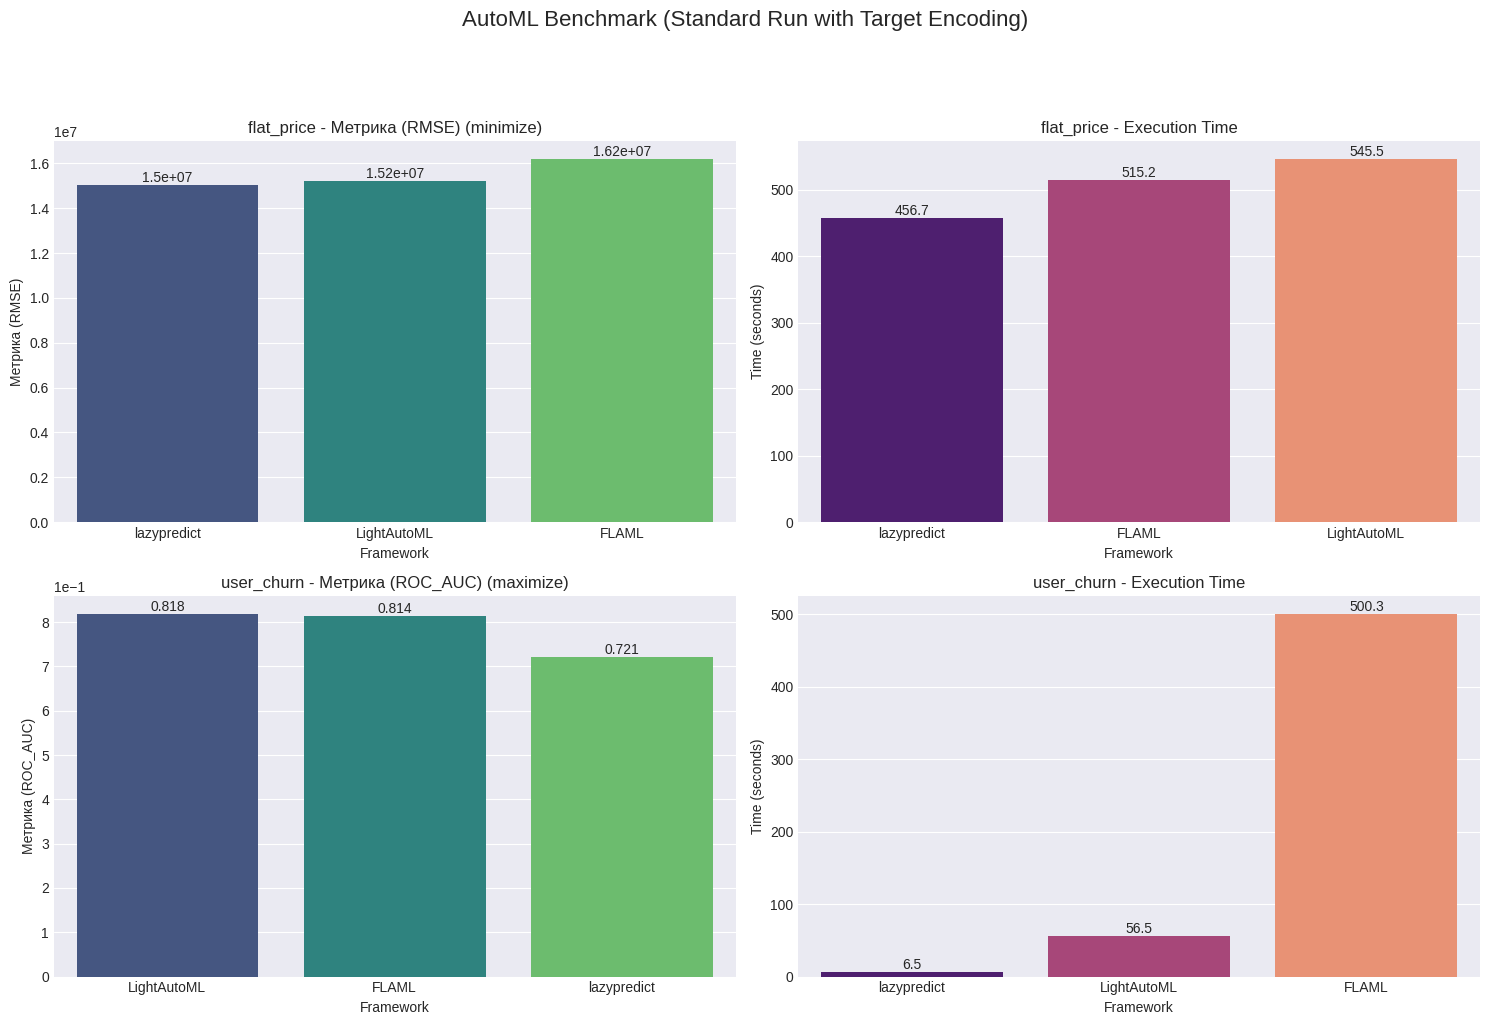


Standard plots saved to automl_standard_te_benchmark_plots.png


In [10]:
print("\n\n=== VISUALIZING STANDARD RESULTS (with Target Encoding) ===")

def plot_benchmark_results(results_dict, tasks_config, plot_title="AutoML Benchmark Comparison"):
    """Визуализирует результаты бенчмарка."""
    plot_data_list = []
    for task_name, task_results in results_dict.items():
        metric_key = f"Метрика ({tasks_config[task_name]['metric'].upper()})"
        for framework, data in task_results.items():
            metric_val_num = pd.to_numeric(data.get('Metric'), errors='coerce')
            time_val_num = pd.to_numeric(data.get('Time'), errors='coerce')
            if pd.notna(metric_val_num) and pd.notna(time_val_num):
                plot_data_list.append({
                    'Задача': task_name,
                    'Фреймворк': framework,
                    'Metric_Name': metric_key,
                    'Metric_Value': metric_val_num,
                    'Время выполнения, сек.': time_val_num,
                    'Goal': tasks_config[task_name]['goal']
                })

    plot_df = pd.DataFrame(plot_data_list)

    if not plot_df.empty:
        plt.style.use('seaborn-v0_8-darkgrid')
        num_tasks = plot_df['Задача'].nunique()
        fig, axes = plt.subplots(nrows=num_tasks, ncols=2, figsize=(15, 5 * num_tasks), squeeze=False)
        fig.suptitle(plot_title, fontsize=16, y=1.02)

        row_idx = 0
        for task_name, group_df in plot_df.groupby('Задача'):
            metric_col_name = group_df['Metric_Name'].iloc[0]
            goal = group_df['Goal'].iloc[0]

            ax_metric = axes[row_idx, 0]
            sns.barplot(x='Фреймворк', y='Metric_Value', data=group_df, ax=ax_metric, palette='viridis', order=group_df.sort_values('Metric_Value', ascending=(goal=='minimize')).Фреймворк)
            ax_metric.set_title(f'{task_name} - {metric_col_name} ({goal})')
            ax_metric.set_ylabel(metric_col_name)
            ax_metric.set_xlabel('Framework')
            ax_metric.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            for container in ax_metric.containers:
                ax_metric.bar_label(container, fmt='%.3g')

            ax_time = axes[row_idx, 1]
            sns.barplot(x='Фреймворк', y='Время выполнения, сек.', data=group_df, ax=ax_time, palette='magma', order=group_df.sort_values('Время выполнения, сек.').Фреймворк)
            ax_time.set_title(f'{task_name} - Execution Time')
            ax_time.set_ylabel('Time (seconds)')
            ax_time.set_xlabel('Framework')
            ax_time.ticklabel_format(style='plain', axis='y')
            for container in ax_time.containers:
                ax_time.bar_label(container, fmt='%.1f')

            row_idx += 1

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    else:
        print("Нет данных для визуализации.")
    return fig

standard_fig = plot_benchmark_results(standard_te_results, TASKS,
                                      plot_title="AutoML Benchmark (Standard Run with Target Encoding)")
# Сохранение графика (опционально)
standard_fig.savefig("automl_standard_te_benchmark_plots.png", bbox_inches='tight')
print("\nStandard plots saved to automl_standard_te_benchmark_plots.png")

In [11]:
print("\n\n=== RUNNING PARALLEL BENCHMARK (with Target Encoding) ===")
parallel_te_results = run_automl_comparison(TASKS, FRAMEWORKS,
                                            run_settings=PARALLEL_RUN_SETTINGS,
                                            use_target_encoding=True)
print("\n=== PARALLEL BENCHMARK (with Target Encoding) FINISHED ===")



=== RUNNING PARALLEL BENCHMARK (with Target Encoding) ===

=============== Starting Task: user_churn (classification) ===============
Using Preprocessing with: Target Encoding
--- Running Preprocessing ---
Using noise_scale: 0.05
Preprocessing Churn data: train_churn.csv, test_churn.csv...
Column 'HasPhoneService' mapped to binary.
Column 'HasPartner' mapped to binary.
Column 'HasChild' mapped to binary.
Column 'IsBillingPaperless' mapped to binary.
Applying noisy target encoding to: ['HasMovieSubscription', 'HasMultiplePhoneNumbers', 'HasTechSupportAccess', 'HasInternetService', 'PaymentMethod', 'HasOnlineTV', 'HasContractPhone', 'HasDeviceProtection', 'Sex', 'HasOnlineSecurityService', 'HasOnlineBackup']
Applying noisy target encoding to 'HasMovieSubscription'...
  Detected binary-like target for 'HasMovieSubscription'. Ensuring 0/1 for mean calculation.
  Finished encoding 'HasMovieSubscription' into 'HasMovieSubscription_TgtEncoded'.
Applying noisy target encoding to 'HasMultiple

100%|███████████████████████████████████████████| 29/29 [00:06<00:00,  4.63it/s]



LazyPredict Classifier Model Performance (Sorted by Time):
| Model                         |   Accuracy |   Balanced Accuracy |   ROC AUC |   F1 Score |   roc_auc_score |   Time Taken |
|:------------------------------|-----------:|--------------------:|----------:|-----------:|----------------:|-------------:|
| LabelSpreading                |     0.7062 |              0.6144 |    0.6144 |     0.7055 |          0.6144 |       1.3178 |
| LabelPropagation              |     0.7049 |              0.6136 |    0.6136 |     0.7044 |          0.6136 |       1.0180 |
| RandomForestClassifier        |     0.7591 |              0.6438 |    0.6438 |     0.7465 |          0.6438 |       0.9420 |
| NuSVC                         |     0.7755 |              0.6246 |    0.6246 |     0.7465 |          0.6246 |       0.4241 |
| AdaBoostClassifier            |     0.7617 |              0.6566 |    0.6566 |     0.7524 |          0.6566 |       0.4234 |
| BaggingClassifier             |     0.7579 |     

100%|███████████████████████████████████████████| 42/42 [07:46<00:00, 11.10s/it]


LazyPredict Regressor Model Performance (Sorted by Time):
| Model                         |   Adjusted R-Squared |   R-Squared |          RMSE |   Time Taken |      <lambda> |
|:------------------------------|---------------------:|------------:|--------------:|-------------:|--------------:|
| NuSVR                         |              -0.0359 |     -0.0337 | 30024449.2442 |     109.7008 | 30024449.2442 |
| SVR                           |              -0.0914 |     -0.0891 | 30817570.8707 |     101.5877 | 30817570.8707 |
| RandomForestRegressor         |               0.7185 |      0.7191 | 15650964.8760 |      91.7472 | 15650964.8760 |
| QuantileRegressor             |              -0.0914 |     -0.0891 | 30818872.4180 |      60.9213 | 30818872.4180 |
| MLPRegressor                  |              -0.8319 |     -0.8280 | 39927056.8455 |      30.0684 | 39927056.8455 |
| GradientBoostingRegressor     |               0.6933 |      0.6940 | 16336260.3190 |      25.1525 | 16336260.3190


/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10/site-packages/lightautoml/transformers/categorical.py:447: RuntimeWarning: invalid value encountered in cast
  target = dataset.target.astype(np.int32)
/home/radioactive/.local/lib/python3.10

LightAutoML fit_predict completed in 601.99 seconds.
Prediction on test data completed. Shape: (9021, 1)
Calculating metric on test set...
Metric calculation successful.
LightAutoML finished. Test RMSE: 15223730.3026. Time: 601.99 seconds.

--- Running Framework: FLAML ---

--- Running FLAML for regression (Time Budget: 1800, n_jobs: -1) ---
[flaml.automl.logger: 04-22 16:43:07] {1728} INFO - task = regression
[flaml.automl.logger: 04-22 16:43:07] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-22 16:43:07] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 04-22 16:43:07] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 04-22 16:43:07] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-22 16:43:07] {2393} INFO - Estimated sufficient time budget=2216s. Estimated necessary time budget=19s.
[flaml.automl.logger: 04-22 16:43:07] {2442} INFO -

In [12]:
print("\n\n=== PARALLEL BENCHMARK RESULTS (with Target Encoding) ===")
parallel_te_results_df_formatted = format_results_table(parallel_te_results, TASKS)
print(parallel_te_results_df_formatted.to_markdown())

# Сохранение в CSV (опционально)
parallel_te_results_df_formatted.to_csv("automl_parallel_te_benchmark_results.csv")
print("\nParallel results saved to automl_parallel_te_benchmark_results.csv")



=== PARALLEL BENCHMARK RESULTS (with Target Encoding) ===
| Фреймворк   |
|:------------|
| FLAML       |
| LightAutoML |
| lazypredict |

Parallel results saved to automl_parallel_te_benchmark_results.csv




=== VISUALIZING PARALLEL RESULTS (with Target Encoding) ===


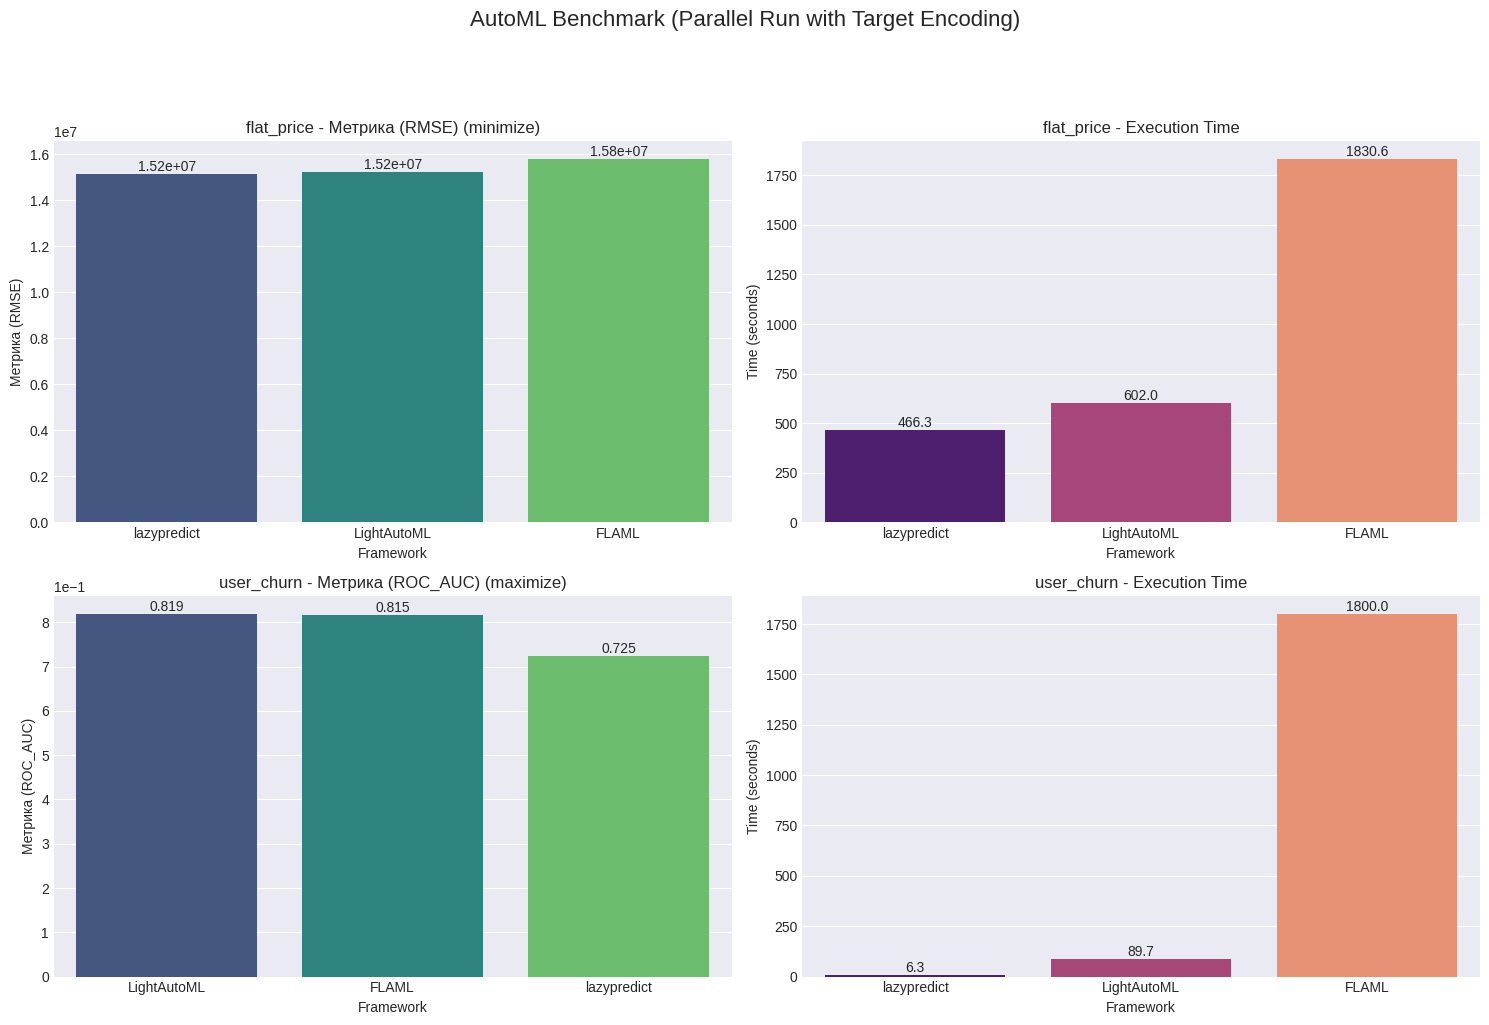


Parallel plots saved to automl_parallel_te_benchmark_plots.png


In [13]:
print("\n\n=== VISUALIZING PARALLEL RESULTS (with Target Encoding) ===")
parallel_fig = plot_benchmark_results(parallel_te_results, TASKS,
                                      plot_title="AutoML Benchmark (Parallel Run with Target Encoding)")
# Сохранение графика (опционально)
parallel_fig.savefig("automl_parallel_te_benchmark_plots.png", bbox_inches='tight')
print("\nParallel plots saved to automl_parallel_te_benchmark_plots.png")